<a href="https://colab.research.google.com/github/OSolerHugo/Data_science_Study/blob/main/Anac_TimeSerie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will utilize data from ANAC, the Brazilian agency for civil aviation, to predict the number of air passengers for the upcoming month in Brazil. By analyzing historical data and implementing machine learning techniques, we aim to develop a reliable model for forecasting passenger volumes. This information will assist in optimizing resource allocation and decision-making processes in the aviation industry. Let's proceed with the data exploration and prediction.

Firstly we will to upload and clean the data

In [34]:
from zipfile import ZipFile
from urllib.request import urlopen
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


from google.colab import drive
drive.mount('drive')


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [12]:
URL = \
    'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/dados-estatisticos/arquivos/Dados_Estatisticos.zip'



# open and save the zip file onto computer
#url = urlopen(URL)
#output = open('drive/My Drive/coolab/ANAC-Estudo/Dados_Estatisticos.zip', 'wb')
#output.write(url.read())
#output.close()

# read the zip file as a pandas dataframe
df = pd.read_csv('drive/My Drive/coolab/ANAC-Estudo/Dados_Estatisticos.csv', sep=';', encoding='latin1', decimal = ",")

# if keeping on disk the zip file is not wanted, then:
#os.remove('Dados_Estatisticos.zip')   # remove the copy of the zipfile on disk
df_raw=df.fillna('')
df_raw.head()

,EMPRESA (SIGLA),EMPRESA (NOME),EMPRESA (NACIONALIDADE),ANO,MÊS,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE ORIGEM (NOME),AEROPORTO DE ORIGEM (UF),AEROPORTO DE ORIGEM (REGIÃO),AEROPORTO DE ORIGEM (PAÍS),...,COMBUSTÍVEL (LITROS),DISTÂNCIA VOADA (KM),DECOLAGENS,CARGA PAGA KM,CARGA GRATIS KM,CORREIO KM,ASSENTOS,PAYLOAD,HORAS VOADAS,BAGAGEM (KG)
0,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2011,1,KAUS,"AUSTIN, TEXAS",,,ESTADOS UNIDOS DA AMÉRICA,...,,306.0,1.0,2946780.0,0.0,0.0,246.0,45000.0,2.5,
1,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2011,1,KDFW,"DALLAS & FORT WORTH, TEXAS",,,ESTADOS UNIDOS DA AMÉRICA,...,,109447.0,13.0,243334000.0,0.0,53561700.0,2847.0,455000.0,136.88,
2,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2011,1,KDFW,"DALLAS & FORT WORTH, TEXAS",,,ESTADOS UNIDOS DA AMÉRICA,...,,247320.0,30.0,2461640000.0,0.0,76685700.0,7380.0,1350000.0,299.5,
3,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2011,1,KJFK,"NEW YORK, NEW YORK",,,ESTADOS UNIDOS DA AMÉRICA,...,,216412.0,28.0,370119000.0,0.0,316224000.0,6132.0,1010000.0,285.26,
4,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2011,1,KJFK,"NEW YORK, NEW YORK",,,ESTADOS UNIDOS DA AMÉRICA,...,,7664.0,1.0,49624400.0,0.0,0.0,246.0,45000.0,10.22,


In [13]:
list(df_raw.columns.values)

['EMPRESA (SIGLA)',
 'EMPRESA (NOME)',
 'EMPRESA (NACIONALIDADE)',
 'ANO',
 'MÊS',
 'AEROPORTO DE ORIGEM (SIGLA)',
 'AEROPORTO DE ORIGEM (NOME)',
 'AEROPORTO DE ORIGEM (UF)',
 'AEROPORTO DE ORIGEM (REGIÃO)',
 'AEROPORTO DE ORIGEM (PAÍS)',
 'AEROPORTO DE ORIGEM (CONTINENTE)',
 'AEROPORTO DE DESTINO (SIGLA)',
 'AEROPORTO DE DESTINO (NOME)',
 'AEROPORTO DE DESTINO (UF)',
 'AEROPORTO DE DESTINO (REGIÃO)',
 'AEROPORTO DE DESTINO (PAÍS)',
 'AEROPORTO DE DESTINO (CONTINENTE)',
 'NATUREZA',
 'GRUPO DE VOO',
 'PASSAGEIROS PAGOS',
 'PASSAGEIROS GRÁTIS',
 'CARGA PAGA (KG)',
 'CARGA GRÁTIS (KG)',
 'CORREIO (KG)',
 'ASK',
 'RPK',
 'ATK',
 'RTK',
 'COMBUSTÍVEL (LITROS)',
 'DISTÂNCIA VOADA (KM)',
 'DECOLAGENS',
 'CARGA PAGA KM',
 'CARGA GRATIS KM',
 'CORREIO KM',
 'ASSENTOS',
 'PAYLOAD',
 'HORAS VOADAS',
 'BAGAGEM (KG)']

To streamline our study, we will create a new dataset that includes only the essential columns: 'AEROPORTO DE ORIGEM (SIGLA)', 'AEROPORTO DE DESTINO (SIGLA)', 'NATUREZA', 'ASSENTOS', and 'PASSAGEIROS'. However, before proceeding, we need to merge the columns 'PASSAGEIROS PAGOS' and 'PASSAGEIROS GRÁTIS' to create the 'PASSAGEIROS' column, which will represent the total number of passengers. This will allow us to focus on the relevant information for our analysis and prediction.

In [14]:
df=df.rename(columns={list(df)[4]:'MES'})
df_seats=df[['AEROPORTO DE ORIGEM (SIGLA)',
                'AEROPORTO DE DESTINO (SIGLA)','NATUREZA','ASSENTOS']]

df_seats.loc[:,'PASSAGEIROS']=df.loc[:,'PASSAGEIROS PAGOS'].add(df.loc[:,'PASSAGEIROS GRÁTIS'])
df_seats.loc[:,'DATA']=pd.to_datetime(df.ANO.astype(str) + '/' + df.MES.astype(str) + '/01')
df_seats.head()

<ipython-input-14-5f61ad9ab024>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seats.loc[:,'PASSAGEIROS']=df.loc[:,'PASSAGEIROS PAGOS'].add(df.loc[:,'PASSAGEIROS GRÁTIS'])
<ipython-input-14-5f61ad9ab024>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seats.loc[:,'DATA']=pd.to_datetime(df.ANO.astype(str) + '/' + df.MES.astype(str) + '/01')


,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE DESTINO (SIGLA),NATUREZA,ASSENTOS,PASSAGEIROS,DATA
0,KAUS,KDFW,INTERNACIONAL,246.0,0.0,2011-01-01
1,KDFW,SBGL,INTERNACIONAL,2847.0,2442.0,2011-01-01
2,KDFW,SBGR,INTERNACIONAL,7380.0,6974.0,2011-01-01
3,KJFK,SBGL,INTERNACIONAL,6132.0,5187.0,2011-01-01
4,KJFK,SBGR,INTERNACIONAL,246.0,220.0,2011-01-01


To enhance clarity and consistency, we will update the column names to English.

In [15]:
df_seats.rename(columns = {'AEROPORTO DE ORIGEM (SIGLA)':'Origin_Airport',
                           'AEROPORTO DE DESTINO (SIGLA)':'Destination_Airport',
                           'NATUREZA':'Nature', 'ASSENTOS':'Seats',
                           'PASSAGEIROS':'Passengers', 'DATA':'Date'}
                           ,inplace = True)
df_seats.head()

<ipython-input-15-9f41e7cecd1e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seats.rename(columns = {'AEROPORTO DE ORIGEM (SIGLA)':'Origin_Airport',


,Origin_Airport,Destination_Airport,Nature,Seats,Passengers,Date
0,KAUS,KDFW,INTERNACIONAL,246.0,0.0,2011-01-01
1,KDFW,SBGL,INTERNACIONAL,2847.0,2442.0,2011-01-01
2,KDFW,SBGR,INTERNACIONAL,7380.0,6974.0,2011-01-01
3,KJFK,SBGL,INTERNACIONAL,6132.0,5187.0,2011-01-01
4,KJFK,SBGR,INTERNACIONAL,246.0,220.0,2011-01-01


To ensure the quality and reliability of our dataset, we will remove the seats equal zero or unfilled, same for passengers.

In [16]:
df_seats = df_seats[df_seats['Seats'] != 0]
df_seats = df_seats[df_seats['Seats'] != '']
df_seats = df_seats[df_seats['Passengers'] != 0]
df_seats = df_seats[df_seats['Passengers'] != '']
df_seats = df_seats.dropna()

df_seats.head()

,Origin_Airport,Destination_Airport,Nature,Seats,Passengers,Date
1,KDFW,SBGL,INTERNACIONAL,2847.0,2442.0,2011-01-01
2,KDFW,SBGR,INTERNACIONAL,7380.0,6974.0,2011-01-01
3,KJFK,SBGL,INTERNACIONAL,6132.0,5187.0,2011-01-01
4,KJFK,SBGR,INTERNACIONAL,246.0,220.0,2011-01-01
5,KJFK,SBGR,INTERNACIONAL,6888.0,6317.0,2011-01-01


To proceed with the conversion of non-numeric features to numeric features. For that we will use the p

In [17]:
def sigla_select(f,x):
    return(x.index(f))

def apply_impl(df,line,x):
  return df.apply(
      lambda row:
        sigla_select(
          row[line],x),
      axis=1)


sigla_o= df_seats.Origin_Airport.unique()
sigla_o=sorted(sigla_o)

sigla_d=df_seats.Destination_Airport.unique()
sigla_d=sorted(sigla_d)

sigla_nat= df_seats.Nature.unique()
sigla_nat=sorted(sigla_nat)

column_name='Origin_Airport'
df_seats[column_name] = apply_impl(df_seats,column_name,sigla_o)

line_name='Destination_Airport'
df_seats[line_name] = apply_impl(df_seats,line_name,sigla_d)

line_name='Nature'
df_seats[line_name] = apply_impl(df_seats,line_name,sigla_nat)


In [18]:
df_seats.head()

,Origin_Airport,Destination_Airport,Nature,Seats,Passengers,Date
1,42,187,1,2847.0,2442.0,2011-01-01
2,42,190,1,7380.0,6974.0,2011-01-01
3,49,187,1,6132.0,5187.0,2011-01-01
4,49,190,1,246.0,220.0,2011-01-01
5,49,190,1,6888.0,6317.0,2011-01-01


To visualize the relationship between passengers and seats for each date, we can create a plot that displays this information

In [19]:
df_m=df_seats[['Destination_Airport','Seats','Passengers','Date']]
df_m=df_m.resample('M', on='Date').agg({'Passengers':'sum', 'Seats':'sum',
                                 })
df_m.head()

,Passengers,Seats
Date,,
2011-01-31,8536520.0,12777401.0
2011-02-28,6917470.0,11539179.0
2011-03-31,8030635.0,12745646.0
2011-04-30,8075282.0,12226380.0
2011-05-31,7850300.0,12752076.0


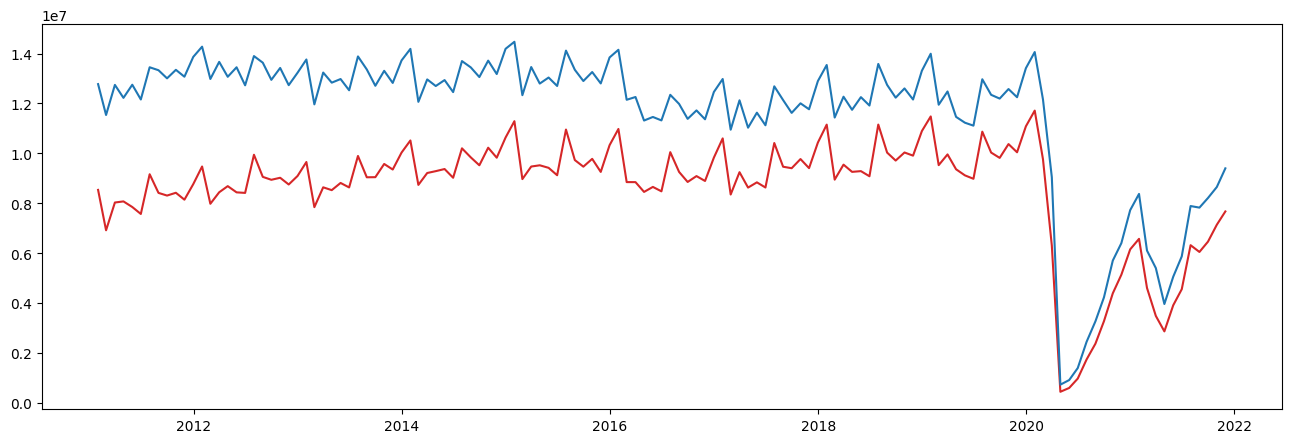

In [20]:
# Draw Plot

plt.figure(figsize=(16,5))
plt.plot(df_m.index, df_m.Passengers, color='tab:red')
plt.plot(df_m.index, df_m.Seats, color='tab:blue')

#plt.xlim([datetime.date(2019, 1, 26), datetime.date(2021, 12, 1)])
plt.show()

The passengers and seats exhibit a strong correlation. We will utilize the SARIMAX model to predict the number of passengers for the next month. SARIMAX is a seasonal ARIMA model that incorporates exogenous regressors, making it suitable for time series analysis with seasonality. This model enables us to capture the patterns and variations in passenger data effectively.

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


In [62]:
# fit an SARIMAX model and make a one step prediction
def Sarimax_forecast(train):

	train = np.asarray(train)

	modelo = SARIMAX(train,order=(1,1,1),seasonal_order=(0,1,1,12))
	resultado=modelo.fit()


	yhat = resultado.predict(start=len(train),end=(len(train)+1))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_SARIMAX(data, n_test):

	predictions = list()
	train, test = data[:-n_test], data[-n_test:]
	history = [x for x in train]

	for i in range(len(test)):
		yhat = Sarimax_forest_forecast(history)
		if yhat<0: yhat = 0 #No make sense has negative numbers of passengers.
		predictions.append(yhat)
		history.append(test[i])
		print('predicted=%.1f \t %1.f/%1.f' % ( yhat,(i+1),len(test)))

  # estimate prediction error
	error = mean_absolute_error(test, predictions)
	return error, predictions

In [57]:
error_sarimax,ex_pred=walk_forward_SARIMAX(df_m.Passengers.values, 48)

predicted=10345731.5 	 1/48
predicted=11197883.7 	 2/48
predicted=8910558.3 	 3/48
predicted=9826925.0 	 4/48
predicted=8954949.6 	 5/48
predicted=9437438.7 	 6/48
predicted=9113106.7 	 7/48
predicted=10844260.0 	 8/48
predicted=10201770.8 	 9/48
predicted=9981061.1 	 10/48
predicted=10083727.0 	 11/48
predicted=9673792.3 	 12/48
predicted=10919533.2 	 13/48
predicted=11625259.6 	 14/48
predicted=9277212.8 	 15/48
predicted=10119237.3 	 16/48
predicted=9684102.9 	 17/48
predicted=9400461.0 	 18/48
predicted=8926041.5 	 19/48
predicted=11036631.5 	 20/48
predicted=9767885.1 	 21/48
predicted=9691120.7 	 22/48
predicted=10155220.0 	 23/48
predicted=10222153.6 	 24/48
predicted=11054582.1 	 25/48
predicted=11656175.0 	 26/48
predicted=9766681.7 	 27/48
predicted=10188475.3 	 28/48
predicted=5946754.9 	 29/48


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=0.0 	 30/48
predicted=533802.0 	 31/48
predicted=2958768.5 	 32/48
predicted=654433.1 	 33/48
predicted=2392540.1 	 34/48
predicted=3922644.0 	 35/48
predicted=4155209.3 	 36/48
predicted=6345261.2 	 37/48
predicted=6750302.3 	 38/48
predicted=4587292.0 	 39/48
predicted=1573732.7 	 40/48
predicted=0.0 	 41/48
predicted=3566712.4 	 42/48
predicted=4024120.0 	 43/48
predicted=6007574.1 	 44/48
predicted=6261996.8 	 45/48
predicted=6321553.9 	 46/48
predicted=7289235.4 	 47/48
predicted=7326427.1 	 48/48


In [60]:
df_m_pred=pd.concat([df_m,
           pd.DataFrame(ex_pred,index=pd.date_range('2017-12-30 00:00:00', periods=(48),freq='M'))
           ],ignore_index=True, axis=1)

df_m_pred.columns = ['Passengers', 'seats', 'P_SX_Pred']
df_m_pred.head()

,Passengers,seats,P_SX_Pred
2011-01-31,8536520.0,12777401.0,NaN
2011-02-28,6917470.0,11539179.0,NaN
2011-03-31,8030635.0,12745646.0,NaN
2011-04-30,8075282.0,12226380.0,NaN
2011-05-31,7850300.0,12752076.0,NaN


Plotting the prediction and the target of passengers

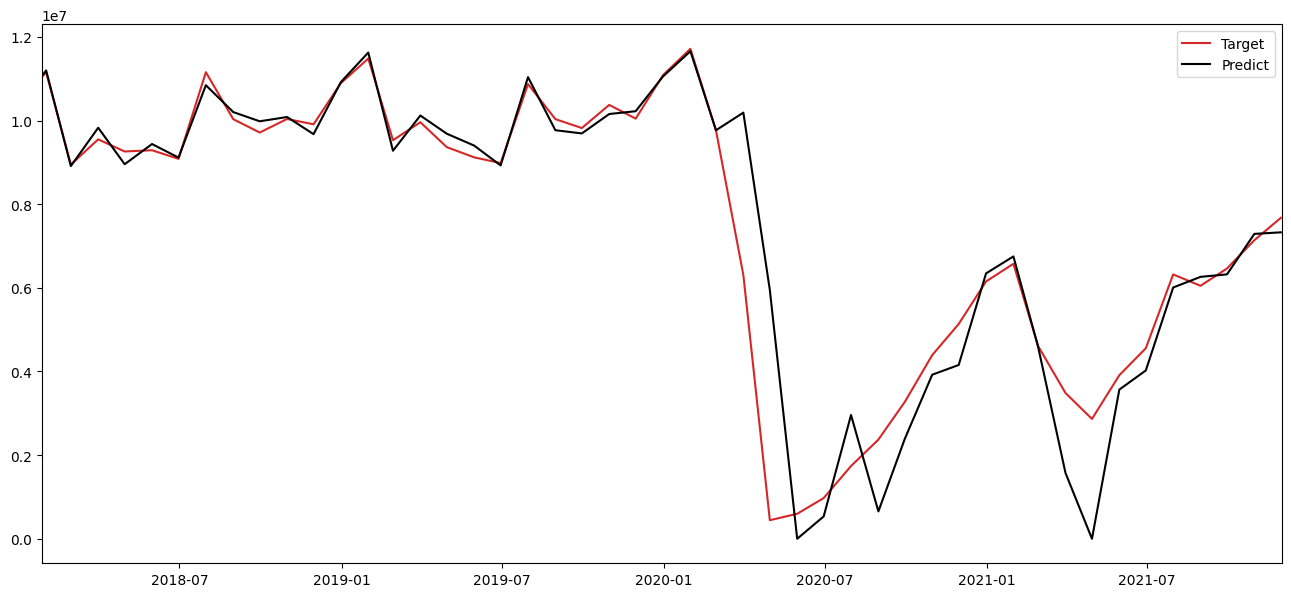

In [61]:
plt.figure(figsize=(16,7))
plt.plot(df_m.index, df_m.Passengers, color='tab:red',label='Target')
plt.plot(df_m_pred.index,df_m_pred.P_SX_Pred,color='black', label='Predict')

plt.xlim([datetime.date(2018, 1, 26), datetime.date(2021, 12, 1)])
plt.legend()
plt.show()

Our SARIMAX model delivers impressive performance in passenger prediction, relying solely on the previous month's passenger count for input, resulting in high efficiency. By utilizing historical data up to 2018, we forecast the following month and continuously refine predictions by evaluating them against actual passenger numbers. This iterative process ensures remarkable accuracy in forecasting passenger counts up to the present month.

Except for pandemic periods, our model's predictions are an excellent tool for trend identification, offering valuable insights into passenger behavior and the ability to anticipate changes in passenger counts with high accuracy. By leveraging historical data and considering various factors, our model provides reliable indications of passenger trends, empowering stakeholders to make informed decisions.

Additionally, one noteworthy feature is the model's capability to predict multiple months ahead. By using the output of the model as input for subsequent predictions, we can easily forecast the passenger count for the next month and continue this process to predict subsequent months.